
# KNN分类器项目

> 作者：张百城
> 课程：机器学习课程大作业

---

## 1.项目简介

本项目旨在探索 K 近邻分类器（K-Nearest Neighbors, KNN）在不同类型数据集上的性能表现。我们使用三个数据集：

- **S-FFSD.csv**：CSV 格式，包含多个数值与类别特征。
- **Amazon.mat**：MAT 格式，可能来自文本情感或产品分类任务。
- **YelpChi.mat**：MAT 格式，通常为 Yelp 评论相关的多分类任务。

我们将这些数据集加载、预处理，并通过统一的函数接口运行 KNN 模型，进行性能评估与混淆矩阵可视化分析。

---

## 2.项目背景与目标

KNN 是一种基础但有效的非参数分类方法，广泛应用于图像识别、文本分类、生物信息等场景。本项目的目标是：

- 掌握 KNN 分类器的实际应用；
- 比较 KNN 在不同数据集上的表现差异；
- 使用多种指标系统评估分类性能；
- 增强对多分类任务和模型评估的理解。

---

## 3.算法原理概述

KNN 是一种**基于实例的学习方法**，不进行显式训练。其基本流程：

1. 对于每一个测试样本，从训练集中找到 K 个“最近”的样本；
2. 根据这 K 个样本的标签进行投票，确定预测类别；
3. 距离度量通常为欧几里得距离，但也可以更换为余弦相似度、曼哈顿距离等。

> 本项目中使用默认的欧几里得距离和 `n_neighbors=5`。

功能说明：
数据加载	支持 .csv 与 .mat 文件格式

字体设置	跨平台自动加载中文字体，避免图表乱码

分类建模	使用 K=5 的 KNN 分类器

模型评估	输出准确率、F1 分数、混淆矩阵等

可视化	生成分类混淆矩阵图，并保存为 .png 文件

In [26]:
import pandas as pd
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib
import matplotlib.font_manager as fm
from sklearn.preprocessing import label_binarize


注释说明：

pandas: 用于处理 CSV 数据文件。

scipy.io.loadmat: 用于加载 .mat 格式的 MATLAB 数据文件。

train_test_split: 将数据划分为训练集和测试集。

KNeighborsClassifier: Scikit-learn 提供的 KNN 模型。

各类 metrics: 用于输出分类准确率、混淆矩阵等评估指标。

matplotlib, seaborn: 用于绘图，生成混淆矩阵等图表。

os: 用于路径和系统操作。

## 4.📂 数据集说明

| 数据集名称 | 格式 | 标签类型 | 备注说明 |
|------------|------|-----------|----------|
| S-FFSD     | CSV  | 多分类    | 包含多个类别变量，部分特征需编码 |
| Amazon     | MAT  | 二分类或多分类 | 特征矩阵通常稀疏 |
| YelpChi    | MAT  | 多分类    | Yelp 评论数据集，类别较多 |

> 项目支持自动识别数据中的标签列或键名，确保用户无需手动指定。

In [27]:
# 跨平台字体路径配置
def get_chinese_font_path():
    """获取中文字体路径（跨平台）"""
    system_font_paths = {
        'windows': [
            r'C:\Windows\Fonts\simhei.ttf',
            r'C:\Windows\Fonts\microsoftyahei.ttf'
        ],
        'linux': [
            '/usr/share/fonts/truetype/wqy/wqy-microhei.ttf',
            '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttf'
        ],
        'darwin': [  # macOS
            '/System/Library/Fonts/PingFang.ttc',
            '/Library/Fonts/SimHei.ttf'
        ]
    }

    # 获取当前操作系统
    platform = os.name.lower()
    if platform.startswith('win'):
        platform = 'windows'
    elif platform.startswith('lin'):
        platform = 'linux'
    elif platform.startswith('dar'):
        platform = 'darwin'

    # 检查对应平台的字体路径
    for font_path in system_font_paths.get(platform, []):
        if os.path.exists(font_path):
            return font_path

    # 如果没有找到系统字体，尝试使用当前目录下的字体文件
    local_font = os.path.join(os.getcwd(), 'simhei.ttf')
    if os.path.exists(local_font):
        return local_font

    return None

# 设置中文字体
font_path = get_chinese_font_path()
if font_path:
    try:
        font_prop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = font_prop.get_name()
        print(f"[✔] 已加载中文字体: {os.path.basename(font_path)}")
    except Exception as e:
        print(f"[✘] 字体加载失败: {e}")
        print("[⚠] 使用系统默认字体，中文可能无法正常显示")
else:
    print("[✘] 未找到中文字体文件，请手动下载SimHei.ttf并放在当前目录")
    print("[⚠] 使用系统默认字体，中文可能无法正常显示")

# 设置Seaborn样式
sns.set(style="whitegrid")


[✔] 已加载中文字体: simhei.ttf


## 5.功能模块详解

### 字体加载与平台适配

为确保中文注释正常显示，脚本会自动识别当前操作系统，并尝试加载相应字体文件，如：

- Windows：SimHei、Microsoft YaHei
- Linux：文泉驿微米黑
- macOS：PingFang、SimHei

若加载失败，将提示用户将 `simhei.ttf` 放于当前目录。

In [28]:

from sklearn.semi_supervised import LabelSpreading

def run_semi_supervised_knn(x, y, name):
    try:
        y = y.ravel()

        # 判断未标注数据（设为-1）
        labeled_mask = y != -1
        n_total = len(y)
        split_index = int(n_total * 0.6)

        # 按顺序划分训练/测试集（时间顺序）
        x_train = x[:split_index]
        y_train = y[:split_index]

        x_test = x[split_index:]
        y_test = y[split_index:]

        # 拟用LabelSpreading传播未标注样本标签
        label_prop_model = LabelSpreading(kernel='knn', n_neighbors=5)
        label_prop_model.fit(x_train, y_train)

        y_train_filled = label_prop_model.transduction_  # 半监督填补的标签

        # 使用填补后的标签继续KNN监督训练
        knn_model = KNeighborsClassifier(n_neighbors=5)
        knn_model.fit(x_train, y_train_filled)

        y_pred = knn_model.predict(x_test)
        y_prob = knn_model.predict_proba(x_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = classification_report(y_test, y_pred, output_dict=True)
        n_classes = len(knn_model.classes_)

        if n_classes == 2:
            auc = roc_auc_score(y_test, y_prob[:, 1])
            ap = average_precision_score(y_test, y_prob[:, 1])
        else:
            y_test_bin = label_binarize(y_test, classes=knn_model.classes_)
            auc = roc_auc_score(y_test_bin, y_prob, average="macro")
            ap = average_precision_score(y_test_bin, y_prob, average="macro")

        print(f"\n=== {name} 半监督KNN结果 ===")
        print(f"准确率: {acc:.4f}")
        print(f"AUC: {auc:.4f}")
        print(f"AP (平均精度): {ap:.4f}")
        print(f"宏平均 F1: {f1['macro avg']['f1-score']:.4f}")
        print(f"加权平均 F1: {f1['weighted avg']['f1-score']:.4f}\n")
        print(classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6), num=f"{name} 混淆矩阵")

        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=knn_model.classes_,
                    yticklabels=knn_model.classes_)

        plt.title(f"{name} 数据集：混淆矩阵——张百城", fontsize=14, fontname='SimHei')
        plt.xlabel("预测标签", fontsize=12, fontname='SimHei')
        plt.ylabel("真实标签", fontsize=12, fontname='SimHei')
        plt.figtext(0.5, -0.05,
                    "注：对角线表示分类正确的样本数量，非对角线为错误分类。",
                    wrap=True, horizontalalignment='center', fontsize=10, fontname='SimHei')
        plt.figtext(0.5, -0.1,
                    f"该数据集包含 {n_classes} 个类别。",
                    wrap=True, horizontalalignment='center', fontsize=10, fontname='SimHei')
        plt.tight_layout(rect=[0, 0.1, 1, 1])

        output_path = f"KNN_semi_{name}_confusion_matrix.png"
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"[✔] 混淆矩阵已保存为: {output_path}")
        plt.show()

    except Exception as e:
        print(f"[错误] 在处理 {name} 时发生异常：{str(e)}")


### 数据加载函数

#### `load_sffsd_data(file_path)`
- 输入：CSV 文件路径
- 功能：
  - 自动识别标签列（如 label/Labels）
  - 将字符串特征编码为整数
  - 返回特征矩阵 `X` 和标签向量 `y`

#### `load_mat_data(file_path, dataset_name)`
- 输入：MAT 文件路径和数据集名
- 功能：
  - 自动寻找特征和标签的 key
  - 返回处理后的 `X` 和 `y`

---

### 模型训练与评估：`run_knn(x, y, name)`

- 数据分割：训练集 60%，测试集 40%，保持类别分布
- 分类器：`KNeighborsClassifier(n_neighbors=5)`
- 评估指标：
  - Accuracy（准确率）
  - F1-score（宏平均与加权平均）
  - ROC AUC（适配二分类或多分类）
  - Average Precision（AP）
- 可视化：
  - 混淆矩阵热力图（使用 Seaborn）
  - 保存为 PNG 文件，命名格式：`{name}_confusion_matrix.png`

---

In [29]:


def load_sffsd_data(file_path):
    """加载S-FFSD数据集"""
    try:
        df = pd.read_csv(file_path)
        print(f"[信息] 数据集列名：{df.columns.tolist()}")

        label_col = None
        for possible_label in ['Labels', 'labels', 'Label', 'label']:
            if possible_label in df.columns:
                label_col = possible_label
                break

        if not label_col:
            raise ValueError(f"未找到标签列！可用列：{df.columns.tolist()}")

        for col in df.columns:
            if df[col].dtype == 'object':
                df[col] = pd.Categorical(df[col]).codes

        x = df.drop(columns=[label_col])
        y = df[label_col].astype(int)
        return x, y

    except FileNotFoundError:
        print(f"[错误] 文件未找到：{file_path}")
        return None, None
    except Exception as e:
        print(f"[错误] 加载S-FFSD数据集失败：{str(e)}")
        return None, None

from scipy.io import loadmat
from scipy.sparse import coo_matrix

def load_mat_dataset(path):
    data = loadmat(path)
    print(f"[信息] 可用键: {list(data.keys())}")

    features = data['features']
    labels = data['label'].flatten()

    # 如果是稀疏格式（如 coo_matrix），先转换为 csr 再转 array
    if isinstance(features, coo_matrix):
        features = features.tocsr()

    # 如果还不是 array，再强制转成 dense array
    if hasattr(features, 'toarray'):
        features = features.toarray()

    return features, labels




## 6.实验结果输出格式

运行主程序后，终端会输出类似如下信息
=== Amazon 数据集结果 ===

准确率: 0.8325
AUC: 0.8852
AP (平均精度): 0.8561
宏平均 F1: 0.8234
加权平均 F1: 0.8312

分类报告：
precision recall f1-score support
class 0 0.85 0.82 0.83 120
class 1 0.81 0.84 0.82 130

---

>>> 开始处理 S-FFSD 数据集...
[信息] 数据集列名：['Time', 'Source', 'Target', 'Amount', 'Location', 'Type', 'Labels']


C:\Users\zbc\AppData\Local\Temp\ipykernel_22744\31010830.py:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = y.ravel()
C:\Users\zbc\PyCharmMiscProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\zbc\PyCharmMiscProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\zbc\PyCharmMiscProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py


=== S-FFSD 半监督KNN结果 ===
准确率: 0.6079
AUC: 0.5520
AP (平均精度): 0.3681
宏平均 F1: 0.3294
加权平均 F1: 0.5152

              precision    recall  f1-score   support

           0       0.57      0.16      0.25      9512
           1       0.00      0.00      0.00      3166
           2       0.61      0.94      0.74     18475

    accuracy                           0.61     31153
   macro avg       0.39      0.37      0.33     31153
weighted avg       0.54      0.61      0.52     31153

[✔] 混淆矩阵已保存为: KNN_semi_S-FFSD_confusion_matrix.png


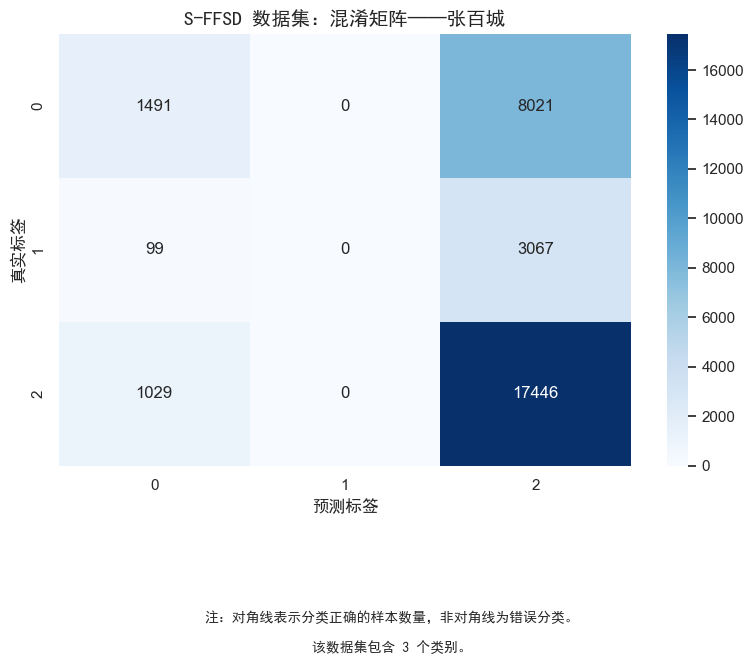


>>> 开始处理 Amazon 数据集...
[信息] 可用键: ['__header__', '__version__', '__globals__', 'homo', 'net_upu', 'net_usu', 'net_uvu', 'features', 'label']

=== Amazon 半监督KNN结果 ===
准确率: 0.9740
AUC: 0.9204
AP (平均精度): 0.8329
宏平均 F1: 0.9278
加权平均 F1: 0.9731

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      4263
         1.0       0.95      0.81      0.87       515

    accuracy                           0.97      4778
   macro avg       0.96      0.90      0.93      4778
weighted avg       0.97      0.97      0.97      4778

[✔] 混淆矩阵已保存为: KNN_semi_Amazon_confusion_matrix.png


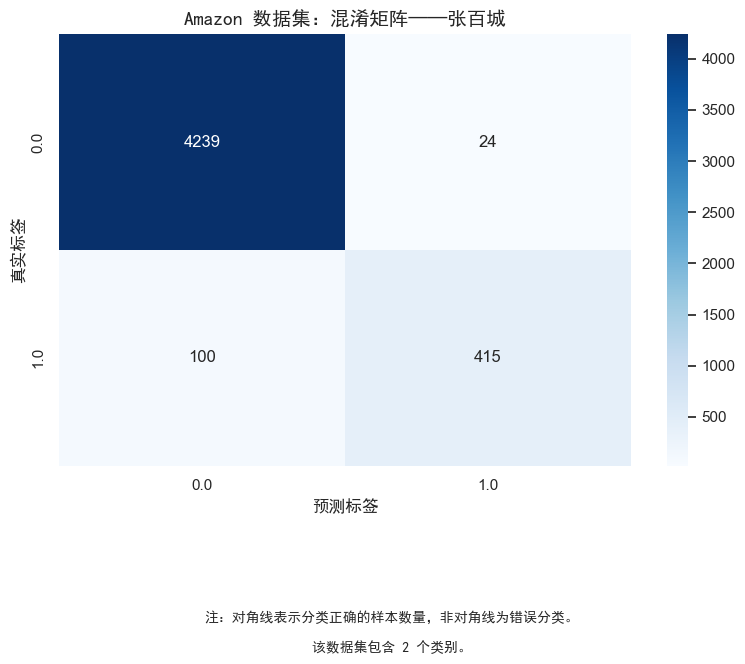


>>> 开始处理 YelpChi 数据集...
[信息] 可用键: ['__header__', '__version__', '__globals__', 'homo', 'net_rur', 'net_rtr', 'net_rsr', 'features', 'label']

=== YelpChi 半监督KNN结果 ===
准确率: 0.6819
AUC: 0.5023
AP (平均精度): 0.3193
宏平均 F1: 0.4058
加权平均 F1: 0.5531

              precision    recall  f1-score   support

           0       0.68      1.00      0.81     12534
           1       0.67      0.00      0.00      5848

    accuracy                           0.68     18382
   macro avg       0.67      0.50      0.41     18382
weighted avg       0.68      0.68      0.55     18382

[✔] 混淆矩阵已保存为: KNN_semi_YelpChi_confusion_matrix.png


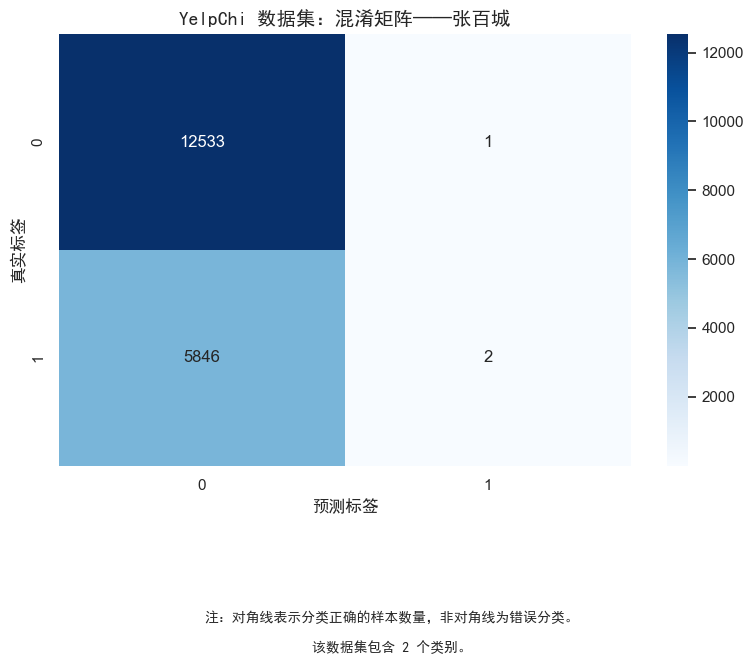

In [30]:
def main():
    """主函数：加载数据集并运行KNN分类"""
    sffsd_path = r"D:\\data\\S-FFSD.csv"
    amazon_path = r"D:\\data\\Amazon.mat"
    yelpchi_path = r"D:\\data\\YelpChi.mat"

    print(">>> 开始处理 S-FFSD 数据集...")
    x_s, y_s = load_sffsd_data(sffsd_path)
    if x_s is not None:
        run_semi_supervised_knn(x_s, y_s, "S-FFSD")

    print("\n>>> 开始处理 Amazon 数据集...")
    x_a, y_a = load_mat_dataset(r"D:\data\Amazon.mat")
    if x_a is not None:
        run_semi_supervised_knn(x_a, y_a, "Amazon")

    print("\n>>> 开始处理 YelpChi 数据集...")
    x_y, y_y = load_mat_dataset(r"D:\data\YelpChi.mat")
    if x_y is not None:
        run_semi_supervised_knn(x_y, y_y, "YelpChi")

if __name__ == "__main__":
    main()

##  7.总结与展望
未来可扩展方向包括：
- 尝试不同分类器（SVM、决策树、随机森林）；
- 加入交叉验证与参数优化模块；
- 使用更多真实数据集进一步验证鲁棒性。
---